In [4]:
import sys
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import importlib

sys.path.append('/om2/user/msaddler/python-packages/bez2018model')
import bez2018model
importlib.reload(bez2018model)

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli


In [5]:
kwargs_nervegram_meanrates = {
    'meanrates_params': {
        'dur': 0.050,
        'fs': 20e3,
        'buffer_start_dur': 0.07,
        'buffer_end_dur': 0.01,
    },
    'ANmodel_params': {
        'cf_list': np.linspace(125, 14e3, 100),
#         'num_cfs': 100,
#         'min_cf': 125,
#         'max_cf': 14e3,
        'species': 4,
        'spont_list': [70.0],
        'cohc': 1.0,
        'bandwidth_scale_factor': 500.0,
        'IhcLowPass_cutoff': 3000.0,
        'IhcLowPass_order': 7,
    },
}


sr = 32000
fs = sr
f0 = 300
dur = 0.150
y = util_stimuli.complex_tone(f0,
                              fs,
                              dur=dur,
                              harmonic_numbers=np.arange(1, 600),
                              frequencies=None,
                              amplitudes=None,
                              phase_mode='sine',
                              offset_start=True,
                              strict_nyquist=False)
noise = util_stimuli.TENoise(fs, dur, dBSPL_per_ERB=70.0)

snr = 20
dBSPL = 60
y = util_stimuli.combine_signal_and_noise(y, noise, snr, mean_subtract=True)
y = util_stimuli.set_dBSPL(y, dBSPL)


ipd.display(ipd.Audio(y, rate=sr))

out_dict = bez2018model.nervegram_meanrates(y, sr, **kwargs_nervegram_meanrates)
for k in out_dict.keys():
    if isinstance(out_dict[k], np.ndarray):
        print(k, out_dict[k].shape)


pin (5000,)
signal (1600,)
cf_list (100,)
meanrates (100, 1000, 1)
spont_list (1,)


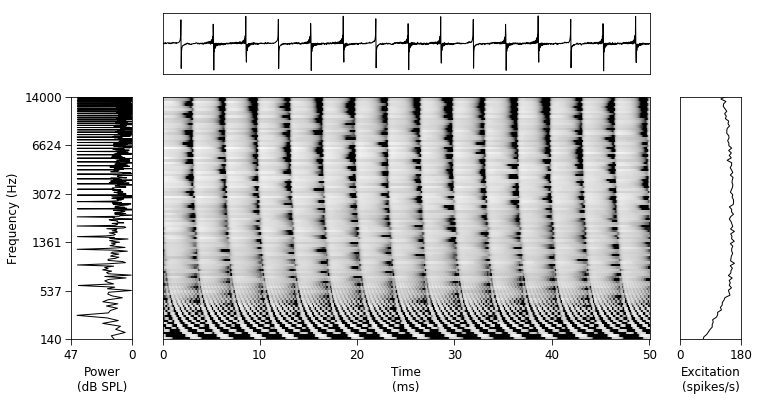

In [6]:
# fxx, pxx = util_stimuli.power_spectrum(y, sr)

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
# ax.plot(fxx, pxx, color='k', lw=1)

# ax.set_xlim([0, 8050])
# ax.set_ylim([0, 30])
# ax.set_xlabel('Frequency (Hz)', fontsize=16)
# ax.set_ylabel('dB/Hz SPL', fontsize=16)
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)

# plt.show()


figsize=(12, 6)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.15,
    'hspace': 0.15,
    'width_ratios': [1, 8, 1],
    'height_ratios': [1, 4],
}

waveform = out_dict['signal']
sr_waveform = out_dict['signal_fs']
nervegram = out_dict['meanrates']
sr_nervegram = out_dict['meanrates_fs']

fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_figures.make_stimulus_summary_plot(ax_arr,
                                        ax_idx_waveform=1,
                                        ax_idx_spectrum=3,
                                        ax_idx_nervegram=4,
                                        ax_idx_excitation=5,
                                        waveform=waveform,
                                        nervegram=nervegram,
                                        sr_waveform=sr_waveform,
                                        sr_nervegram=sr_nervegram,
                                        cfs=out_dict['cf_list'])
plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

color_list = ['k', 'b', 'r', 'y']
for cidx, IHC_cutoff in enumerate([5e3, 4e3, 3e3, 1e3]):

    kwargs_nervegram_meanrates = {
        'meanrates_params': {
            'dur': 0.050,
            'fs':100e3,
            'buffer_start_dur': 0.07,
            'buffer_end_dur': 0.01,
        },
        'ANmodel_params': {
            'num_cfs': 1,
            'min_cf':5000,
            'max_cf':5000,
            'spont_list':[70.0],
            'cohc':1.0,
            'bandwidth_scale_factor':1.0,
            'IhcLowPass_cutoff': IHC_cutoff,
            'IhcLowPass_order': 7,
        },
    }

    np.random.seed(0)
    out_dict = bez2018model.nervegram_meanrates(y, sr, **kwargs_nervegram_meanrates)

    pin_fs = out_dict['pin_fs']
    pin = out_dict['pin']
    mr_fs = out_dict['meanrates_fs']
    mr = out_dict['meanrates']
    freq = out_dict['cf_list']
    pin_fs = out_dict['pin_fs']

    fidx = 0
    print('cf=', freq[fidx])

    mr_trace = mr[fidx, :, 0]
    mr_time = np.arange(0, mr.shape[1]) / mr_fs

    fxx, pxx = util_stimuli.power_spectrum(mr_trace, mr_fs)

    ax[0].plot(mr_time, mr_trace, color=color_list[cidx])
    ax[1].plot(fxx, pxx, color=color_list[cidx], lw=4,
               label='IHC_cutoff={:.0f}Hz'.format(IHC_cutoff))

ax[0].set_xlim([mr_time[0], mr_time[-1]])
ax[0].set_ylabel('spikes/s')
ax[0].set_xlabel('time (s)')
ax[0].set_title('CF={:.2f}, Stimulus_F0={:.2f}'.format(freq[fidx], f0))
ax[1].legend(loc='upper right')

ax[1].set_xlim([0, 8e3])
ax[1].set_ylim([60, 120])
ax[1].set_ylabel('dB')
ax[1].set_xlabel('freq (Hz)')

plt.tight_layout()
plt.show()


In [ ]:
pin_fs = out_dict['pin_fs']
pin = out_dict['pin']
mr_fs = out_dict['meanrates_fs']
mr = out_dict['meanrates']
freq = out_dict['cf_list']
pin_fs = out_dict['pin_fs']

fidx = 0
print('cf=', freq[fidx])

mr_trace = mr[fidx, :, 0]
mr_time = np.arange(0, mr.shape[1]) / mr_fs

fxx, pxx = util_stimuli.power_spectrum(mr_trace, mr_fs)


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))
ax[0].plot(mr_time, mr_trace, color='k')
ax[0].set_xlim([mr_time[0], mr_time[-1]])
ax[0].set_ylabel('spikes/s')
ax[0].set_xlabel('time (s)')
ax[0].set_title('CF={:.2f}, IHC_cutoff={:.2f}'.format(freq[fidx], IHC_cutoff))


ax[1].axvline(IHC_cutoff, color='r', label='IHC_cutoff')
ax[1].axvline(5000, color='b', ls='--', lw=0.5, label='old Nyquist')
ax[1].plot(fxx, pxx, color='k')
ax[1].legend(loc='upper right')

ax[1].set_xlim([0, 8e3])
ax[1].set_ylabel('dB')
ax[1].set_xlabel('freq (Hz)')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

signal = np.random.randn(1000)
noise = np.random.rand(1000)

snr = 60

signal = signal - np.mean(signal)
noise = noise - np.mean(noise)

signal = 0.2 * signal


In [ ]:
# Test nervegram_psth
importlib.reload(bez2018model)

kwargs_nervegram_psth = {
    'nervegram_params': {
        'dur': 0.050,
        'fs': 10e3,
        'buffer_start_dur': 0.07,
        'buffer_end_dur': 0.01,
    },
    'ANmodel_params': {
        'num_anfs': 20,
        'num_cfs': 100,
        'min_cf': 125,
        'max_cf': 14e3,
        'spont_list': [70.0],
        'cohc': 1.0,
        'bandwidth_scale_factor': 1.0,
        'IhcLowPass_cutoff': 3000.0,
        'IhcLowPass_order': 7,
    },
}
out_dict = bez2018model.nervegram_psth(y, sr, **kwargs_nervegram_psth)

for k in sorted(out_dict.keys()):
    if isinstance(out_dict[k], np.ndarray):
        print(k, out_dict[k].shape, out_dict[k].dtype)
    else:
        print(k)


In [ ]:
# Debugging work for custom spike-sampling from meanrates

# rate = out_dict['nervegram_meanrates']
# rate_sr = out_dict['nervegram_fs']
# nervegram_binomial = np.zeros_like(out_dict['nervegram_psth'])
# for itrANF in range(nervegram_binomial.shape[-1]):
#     spikes = np.sign((rate/rate_sr) - np.random.rand(*rate.shape))
#     spikes[spikes < 0] = 0
#     nervegram_binomial[:, :, :, itrANF] = spikes

rate = np.zeros_like(out_dict['nervegram_psth'])
for itrANF in range(rate.shape[-1]):
    rate[:, :, :, itrANF] = out_dict['nervegram_meanrates'].copy()
print(rate.shape)

rate_sr = out_dict['nervegram_fs']
nervegram_binomial = np.zeros_like(out_dict['nervegram_psth'])
dur_refract = int(0.004 * rate_sr)
print(dur_refract)
for t in range(rate.shape[1]):
    t_prob = rate[:, t:t+1, :, :] / rate_sr
    t_spks = np.sign(t_prob - np.random.rand(*t_prob.shape))
    t_spks[t_spks < 0] = 0
#     if t < rate.shape[1] - 1:
#         t_end = min(t + 1 + dur_refract, rate.shape[1])
#         rate[:, t+1:t_end, :, :] *= t_spks == 0
    for t_refract in range(t + 1, t + 1 + dur_refract):
        if t_refract >= rate.shape[1]:
            break
        rate[:, t_refract:t_refract+1, :, :] *= t_spks == 0
    nervegram_binomial[:, t:t+1, :, :] = t_spks

nervegram_binomial.shape


In [ ]:
figsize=(12, 6)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.15,
    'hspace': 0.15,
    'width_ratios': [1, 8, 1],
    'height_ratios': [1, 4],
}

waveform = out_dict['signal']
sr_waveform = out_dict['signal_fs']
nervegram = np.sum(out_dict['nervegram_psth'][:, :, :, 0:200], axis=-1)
# nervegram = np.sum(nervegram_binomial[:, :, :, 0:200], axis=-1)
# nervegram = out_dict['nervegram_meanrates']
sr_nervegram = out_dict['nervegram_fs']

fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_figures.make_stimulus_summary_plot(ax_arr,
                                        ax_idx_waveform=1,
                                        ax_idx_spectrum=3,
                                        ax_idx_nervegram=4,
                                        ax_idx_excitation=5,
                                        waveform=waveform,
                                        nervegram=nervegram,
                                        sr_waveform=sr_waveform,
                                        sr_nervegram=sr_nervegram,
                                        cfs=out_dict['cf_list'])
plt.tight_layout()
plt.show()




nervegram = np.sum(nervegram_binomial[:, :, :, 0:200], axis=-1)

fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
util_figures.make_stimulus_summary_plot(ax_arr,
                                        ax_idx_waveform=1,
                                        ax_idx_spectrum=3,
                                        ax_idx_nervegram=4,
                                        ax_idx_excitation=5,
                                        waveform=waveform,
                                        nervegram=nervegram,
                                        sr_waveform=sr_waveform,
                                        sr_nervegram=sr_nervegram,
                                        cfs=out_dict['cf_list'])
plt.tight_layout()
plt.show()


In [ ]:
spike_counts_1 = []
spike_counts_2 = []

nervegram_1 = out_dict['nervegram_psth']
nervegram_2 = nervegram_binomial

print(nervegram_1.shape, nervegram_2.shape)
assert nervegram_1.shape == nervegram_2.shape
for _ in range(5000):
    idx_cf = np.random.randint(nervegram_1.shape[0])
    idx_dur = np.random.randint(nervegram_1.shape[1])
    idx_start = np.random.randint(nervegram_1.shape[1] - idx_dur)
    idx_anf = np.random.randint(nervegram_1.shape[3])
    
    spike_counts_1.append( np.sum(nervegram_1[idx_cf, idx_start:idx_start+idx_dur, 0, :]) )
    spike_counts_2.append( np.sum(nervegram_2[idx_cf, idx_start:idx_start+idx_dur, 0, :]) )

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(spike_counts_1, spike_counts_2, 'k.', ms=0.5)
ax.plot(spike_counts_1, spike_counts_1, 'r--')
ax.set_xlabel('bez2018model spike counts in random segments')
ax.set_ylabel('binomial spike counts in random segments')

plt.show()


In [ ]:
cf_idx = 48
num_anfs = 20

bez2018model_spikes = np.sum(out_dict['nervegram_psth'][cf_idx:cf_idx+1, :, :, -num_anfs:], axis=(0, 2, 3))
bez2018model_label = 'bez2018model ({} spikes)'.format(int(bez2018model_spikes.sum()))

binomial_spikes = np.sum(nervegram_binomial[cf_idx:cf_idx+1, :, :, -num_anfs:], axis=(0, 2, 3))
binomial_label = 'binomial ({} spikes)'.format(int(binomial_spikes.sum()))

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(bez2018model_spikes + np.max(binomial_spikes) * 1.1, label=bez2018model_label)
ax.plot(binomial_spikes, label=binomial_label)
ax.legend()
plt.show()


In [19]:
import cython_bez2018
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import time

cf = 250.0
pin_fs = 100e3
dur = 0.05
t = np.arange(0, dur, 1/pin_fs)
pin = 1e3*np.sin(2*np.pi*250.0*t)

nrep = 1

t0 = time.time()
for _ in range(nrep):
    vihc = cython_bez2018.run_ihc(pin,
                                  pin_fs,
                                  cf,
                                  species=2,
                                  bandwidth_scale_factor=1,
                                  cohc=1,
                                  cihc=1,
                                  IhcLowPass_cutoff=3000,
                                  IhcLowPass_order=7)
t1 = time.time()

for _ in range(nrep):
    np.random.seed(1)
    out_dict_tmp = cython_bez2018.run_anf(vihc,
                                          pin_fs,
                                          cf,
                                          num_spike_trains=2000,
                                          max_spikes_per_train=500)
t2 = time.time()

for _ in range(nrep):
    np.random.seed(1)
    out_dict = cython_bez2018.run_synapse(vihc,
                                          pin_fs,
                                          cf)
t3 = time.time()

print('time for run_ihc', (t1-t0)/nrep)
print('time for tmp_test', (t2-t1)/nrep)
print('time for run_synapse', (t3-t2)/nrep)

# fig, ax = plt.subplots(figsize=(10, 2))
# ax.plot(t, pin)
# ax.plot(sptime, np.zeros_like(sptime), '.')
# plt.show()
# fig, ax = plt.subplots(figsize=(10, 2))
# ax.plot(t, vihc)
# ax.plot(sptime, np.zeros_like(sptime), '.')
# plt.show()

x0 = out_dict_tmp['meanrate']
x1 = out_dict['meanrate']

for k in out_dict_tmp.keys():
    print(k, out_dict_tmp[k].shape, out_dict_tmp[k].max())

print(np.max(np.abs(x1-x0)))


time for run_ihc 0.016440629959106445
time for tmp_test 1.0147418975830078
time for run_synapse 0.008439064025878906
spike_times (2000, 500) 0.048080000000000324
meanrate (5000,) 209.2814679118423
synout (5000,) 211322.85543143327
0.0


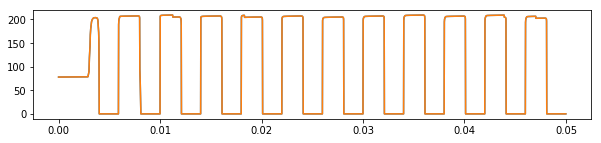

In [20]:
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(t, x0)
ax.plot(t, x1)
plt.show()


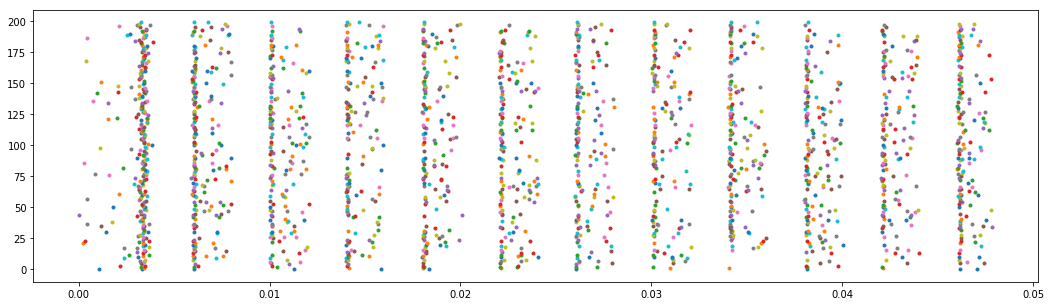

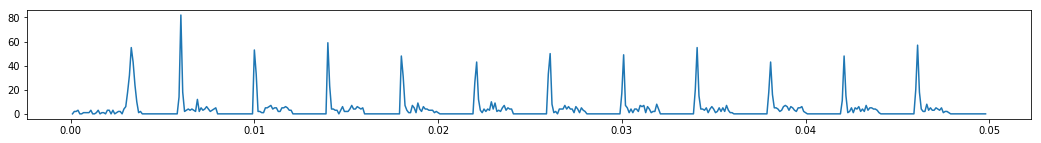

In [9]:
fig, ax = plt.subplots(figsize=(18, 5))

for n in range(out_dict_tmp['spike_times'].shape[0]):
    X = out_dict_tmp['spike_times'][n]
    X = X[X>0]
    ax.plot(X, np.ones_like(X) * n, '.')
plt.show()


t_bins = np.arange(0, dur, 1/10000)

hist, bin_edges = np.histogram(out_dict_tmp['spike_times'], t_bins)
fig, ax = plt.subplots(figsize=(18, 2))
ax.plot(t_bins[1:len(hist)], hist[1:])
plt.show()


In [63]:
X = out_dict_tmp['spike_times']
print(X.shape)

X = X.reshape([-1, 20, 100, 500]).astype(np.float32)
print(X.shape, X.dtype)
print(np.sum(X>0))


(2000, 500)
(1, 20, 100, 500) float32
19191


In [74]:
import tensorflow as tf
from tensorflow.python.ops import math_ops

tf.reset_default_graph()

dur = 2.0
sr = 10000
tensor_spike_times = tf.compat.v1.placeholder(X.dtype, shape=X.shape, name=None)

# Convert lists of spike times to time bin indexes (sampling rate = sr)
# tensor_spike_indexes = tf.cast(tf.math.round(tensor_spike_times * sr), tf.dtypes.int32)
# Convert list of bin indexes to multi-hot spike vectors (new last dimension is time)
# tensor_spike_one_hot = tf.one_hot(indices=tensor_spike_indexes,
#                                   depth=int(dur*sr),
#                                   axis=-1)
# tensor_spike_multi_hot = tf.reduce_sum(tensor_spike_one_hot,
#                                        axis=-2)


def indices_to_multi_hot(indices, depth, parallel_iterations=None, dtype=tf.dtypes.float32):
    '''
    This helper function converts spike time bin indices to a multi-hot array of spikes.
    The explicit double nesting allows for tf.map_fn to serialize operations between and
    within exemplars (preventing OOM due to large dimensions of tf.one_hot outputs).
    NOTE: coding this as a loop will cause tensorflow errors (tensorfow 1.13.0-rc2).
    '''
    fn0 = lambda indices : tf.reduce_sum(tf.one_hot(indices, depth, axis=-1), axis=-2)
    fn1 = lambda indices: tf.map_fn(fn0,
                                    indices,
                                    dtype=dtype,
                                    parallel_iterations=parallel_iterations)
    fn2 = lambda indices: tf.map_fn(fn1,
                                    indices,
                                    dtype=dtype,
                                    parallel_iterations=parallel_iterations)
    return fn2(indices)


def spike_times_to_spike_counts(tensor_spike_times,
                                dur,
                                sr,
                                dtype=tf.dtypes.float32,
                                parallel_iterations=None):
    '''
    '''
    # Convert lists of spike times to time bin indices (sampling rate = sr)
    tensor_spike_indices = tf.cast(tf.math.round(tensor_spike_times * sr), tf.dtypes.int32)
    # Convert lists of spike time indices to multi-hot spike vectors
    tensor_spike_multi_hot = indices_to_multi_hot(tensor_spike_indices,
                                                  depth=int(dur*sr),
                                                  dtype=tf.dtypes.float32,
                                                  parallel_iterations=None)
    # Use boolean mask to remove multiple spikes that accumulate at null spike time
    tensor_mask = tf.math.less_equal(tensor_spike_multi_hot,
                                     tf.ones_like(tensor_spike_multi_hot))
    tensor_spike_multi_hot = tf.math.multiply(tensor_spike_multi_hot,
                                              tf.cast(tensor_mask, tensor_spike_multi_hot.dtype))
    # Sum spikes across fibers
    tensor_spike_counts = tf.reduce_sum(tensor_spike_multi_hot, axis=1)
    return tensor_spike_counts


tensor_spike_counts = spike_times_to_spike_counts(tensor_spike_times,
                                dur,
                                sr,
                                dtype=tf.dtypes.float32,
                                parallel_iterations=None)

with tf.Session() as sess:
    Y = sess.run(tensor_spike_counts, feed_dict={tensor_spike_times: X})
#     print(Y, Y.shape)
    print(Y.max(), Y.min(), Y.sum(), Y.shape)
    


12.0 0.0 19186.0 (1, 100, 20000)


In [73]:
tf.__version__

'1.13.0-rc2'